In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms


#  Deep Learning Image Classifier: Hidden Message Decoding




This project applies deep learning to a challenging visual classification task, where individual images are nearly indistinguishable to the human eye. The model was trained to classify grayscale images (64x64) into 26 distinct classes (A–Z), using a convolutional neural network (CNN).

After training, the model was used to:
1. Predict labels for a separate test set (evaluated by F1 score).
2. Decode a hidden message embedded in a sequence of unlabeled images.

The project demonstrates how neural networks can reveal subtle patterns beyond human perception and be used to extract structured meaning from visual data.



In [3]:
# 1. Loading in the data
# 2. Normalising the data
# 3. Splitting into Validation and Training
# 4. Turning into tensors

# Loading in the Data

In [34]:

import pandas as pd


# --- Dataset class for loading your training data ---
class ImageClassificationDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.image_ids = self.labels_df['id'].values
        self.labels = self.labels_df['class'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = str(self.image_ids[idx]) + ".png"
        label = self.labels[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')  # colour
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Image transform (same as seminar style + normalize) ---
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Correct normalization
# ])

transform = transforms.Compose([
    # transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5]*3, [0.5]*3)
])



# --- Load and split the dataset ---
dataset = ImageClassificationDataset(
    image_dir='data/train',
    labels_csv='data/train/labels_train.csv',
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


# Executing the Code

Epoch 1/50 - Train Loss: 3.2626 | Train Acc: 3.92% | Val Loss: 3.2630 | Val Acc: 3.17%
Epoch 2/50 - Train Loss: 3.2597 | Train Acc: 3.82% | Val Loss: 3.2623 | Val Acc: 3.17%
Epoch 3/50 - Train Loss: 3.2596 | Train Acc: 4.11% | Val Loss: 3.2620 | Val Acc: 3.37%
Epoch 4/50 - Train Loss: 3.2590 | Train Acc: 4.01% | Val Loss: 3.2614 | Val Acc: 3.37%
Epoch 5/50 - Train Loss: 3.2586 | Train Acc: 3.92% | Val Loss: 3.2618 | Val Acc: 3.17%
Epoch 6/50 - Train Loss: 3.2584 | Train Acc: 4.09% | Val Loss: 3.2620 | Val Acc: 3.17%
Epoch 7/50 - Train Loss: 3.2590 | Train Acc: 4.06% | Val Loss: 3.2613 | Val Acc: 3.17%
Epoch 8/50 - Train Loss: 3.2581 | Train Acc: 4.13% | Val Loss: 3.2615 | Val Acc: 3.17%
Epoch 9/50 - Train Loss: 3.2567 | Train Acc: 4.38% | Val Loss: 3.2630 | Val Acc: 3.08%
Epoch 10/50 - Train Loss: 3.2527 | Train Acc: 5.17% | Val Loss: 3.2555 | Val Acc: 4.04%
Epoch 11/50 - Train Loss: 3.2476 | Train Acc: 5.67% | Val Loss: 3.2537 | Val Acc: 4.04%
Epoch 12/50 - Train Loss: 3.2272 | Train 

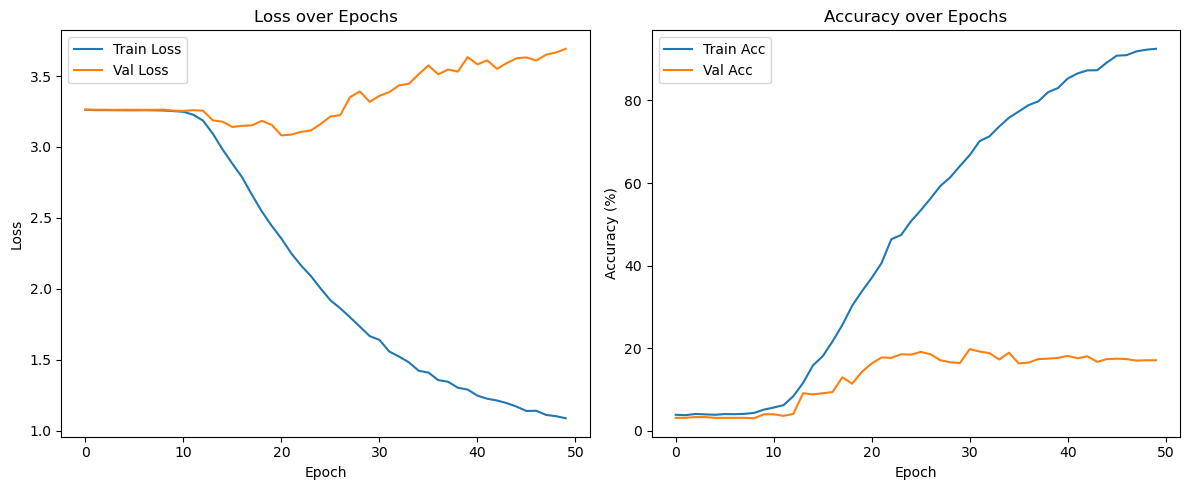

NameError: name 'test_loader' is not defined

In [33]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Model Definition ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 32x32
        x = self.pool(F.relu(self.conv2(x)))  # -> 16x16
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

# --- Training Setup ---
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 👈 updated loss with label smoothing
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# --- For plotting ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# --- Training Loop ---
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# --- Predict on test set and save to CSV ---
model.eval()
test_predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, predicted.cpu().numpy()):
            test_predictions.append((img_id, pred))

# --- Save test predictions ---
df_preds = pd.DataFrame(test_predictions, columns=['id', 'class'])
df_preds.to_csv("YOUR_CANDIDATE_NUMBER_predicted_labels_test.csv", index=False)
print("Test predictions saved.")


In [36]:
# Model with more layers but no batch norming


import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 26)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

    
# --- Training Setup ---
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



# --- For plotting ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# --- Training Loop ---
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# --- Predict on test set and save to CSV ---
model.eval()
test_predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, predicted.cpu().numpy()):
            test_predictions.append((img_id, pred))

# --- Save test predictions ---
df_preds = pd.DataFrame(test_predictions, columns=['id', 'class'])
df_preds.to_csv("YOUR_CANDIDATE_NUMBER_predicted_labels_test.csv", index=False)
print("Test predictions saved.")



Epoch 1/50 - Train Loss: 3.2613 | Train Acc: 3.92% | Val Loss: 3.2607 | Val Acc: 3.65%
Epoch 2/50 - Train Loss: 3.2602 | Train Acc: 3.05% | Val Loss: 3.2604 | Val Acc: 3.65%
Epoch 3/50 - Train Loss: 3.2596 | Train Acc: 3.53% | Val Loss: 3.2608 | Val Acc: 3.65%
Epoch 4/50 - Train Loss: 3.2588 | Train Acc: 3.80% | Val Loss: 3.2618 | Val Acc: 3.65%
Epoch 5/50 - Train Loss: 3.2586 | Train Acc: 3.80% | Val Loss: 3.2619 | Val Acc: 3.65%


KeyboardInterrupt: 

# Medium Model

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

    
# --- Training Setup ---
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- For plotting ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# --- Training Loop ---
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# --- Predict on test set and save to CSV ---
model.eval()
test_predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, predicted.cpu().numpy()):
            test_predictions.append((img_id, pred))

# --- Save test predictions ---
df_preds = pd.DataFrame(test_predictions, columns=['id', 'class'])
df_preds.to_csv("YOUR_CANDIDATE_NUMBER_predicted_labels_test.csv", index=False)
print("Test predictions saved.")




Epoch 1/50 - Train Loss: 3.3327 | Train Acc: 3.34% | Val Loss: 3.2611 | Val Acc: 3.75%
Epoch 2/50 - Train Loss: 3.2601 | Train Acc: 3.65% | Val Loss: 3.2611 | Val Acc: 3.75%
Epoch 3/50 - Train Loss: 3.2597 | Train Acc: 3.63% | Val Loss: 3.2611 | Val Acc: 3.75%
Epoch 4/50 - Train Loss: 3.2594 | Train Acc: 3.87% | Val Loss: 3.2610 | Val Acc: 3.75%
Epoch 5/50 - Train Loss: 3.2590 | Train Acc: 3.87% | Val Loss: 3.2610 | Val Acc: 3.75%
Epoch 6/50 - Train Loss: 3.2588 | Train Acc: 3.97% | Val Loss: 3.2612 | Val Acc: 3.37%


KeyboardInterrupt: 

In [25]:
def __getitem__(self, idx):
    img_name = str(self.image_ids[idx]) + ".png"
    label = self.labels[idx]
    img_path = os.path.join(self.image_dir, img_name)

    print(f"[DEBUG] idx: {idx}, label: {label}, path: {img_path}")

    image = Image.open(img_path).convert('RGB')
    if self.transform:
        image = self.transform(image)
    return image, label

img, label = dataset[0]

from PIL import Image
img = Image.open("data/train/102.png")
img.show()


# New Improved Model with Deeper Layers

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Model Definition ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        # After 4 poolings: 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # → 32x32
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # → 16x16
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # → 8x8
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # → 4x4

        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

# --- Training Setup ---
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- For plotting ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# --- Training Loop ---
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# --- Predict on test set and save to CSV ---
model.eval()
test_predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, predicted.cpu().numpy()):
            test_predictions.append((img_id, pred))

# --- Save test predictions ---
df_preds = pd.DataFrame(test_predictions, columns=['id', 'class'])
df_preds.to_csv("YOUR_CANDIDATE_NUMBER_predicted_labels_test.csv", index=False)
print("Test predictions saved.")


KeyboardInterrupt: 

In [42]:
# --- Custom Dataset class for test images (no labels) ---
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.replace(".png", "")  # Return ID without ".png"

# --- Prediction function ---
def predict_test_data(model, transform, device, candidate_number="YOUR_CANDIDATE_NUMBER"):
    test_dataset = TestDataset("data/test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model.eval()
    predictions = []

    with torch.no_grad():
        for images, image_ids in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for img_id, pred in zip(image_ids, predicted.cpu().numpy()):
                predictions.append((img_id, pred))

    # Save to CSV
    # df = pd.DataFrame(predictions, columns=['id', 'class'])
    # filename = f"{candidate_number}_predicted_labels_test.csv"
    # df.to_csv(filename, index=False)
    # print(f"✅ Test predictions saved to {filename}")


In [43]:
predict_test_data(model, transform, device, candidate_number="12345678")


✅ Test predictions saved to 12345678_predicted_labels_test.csv


In [46]:
def decode_message(model, transform, device):
    message_dir = "data/message"
    image_files = sorted([f for f in os.listdir(message_dir) if f.endswith(".png")])

    model.eval()
    predicted_classes = []

    with torch.no_grad():
        for img_name in image_files:
            img_path = os.path.join(message_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            if transform:
                image = transform(image)
            image = image.unsqueeze(0).to(device)  # add batch dimension
            output = model(image)
            _, pred_class = torch.max(output, 1)
            predicted_classes.append(pred_class.item())

    # Convert 0–25 to A–Z
    message = ''.join([chr(c + ord('A')) for c in predicted_classes])
    print(f"🔐 Decoded Message: {message}")

    # Save it
    with open("YOUR_CANDIDATE_NUMBER_decoded_message.txt", "w") as f:
        f.write(message)

    print("✅ Message saved to YOUR_CANDIDATE_NUMBER_decoded_message.txt")


def visualize_decoded_message(model, transform, device):
    message_dir = "data/message"
    image_files = sorted([f for f in os.listdir(message_dir) if f.endswith(".png")])

    model.eval()
    predictions = []

    plt.figure(figsize=(15, 3))

    with torch.no_grad():
        for i, img_name in enumerate(image_files):
            img_path = os.path.join(message_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            raw_img = image.copy()  # for display
            if transform:
                image = transform(image)
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, pred_class = torch.max(output, 1)
            predictions.append(pred_class.item())

            # Plot
            plt.subplot(1, len(image_files), i + 1)
            plt.imshow(raw_img)
            plt.title(chr(pred_class.item() + ord('A')))
            plt.axis("off")

    plt.suptitle("Predicted Message (One Letter Per Image)", fontsize=16)
    plt.show()

    # Convert to string
    decoded = ''.join([chr(c + ord('A')) for c in predictions])
    print(f"🔍 Raw Model Prediction: {decoded}")



🔐 Decoded Message: CTOAFLYUUNFNQDWNFOOUA
✅ Message saved to YOUR_CANDIDATE_NUMBER_decoded_message.txt


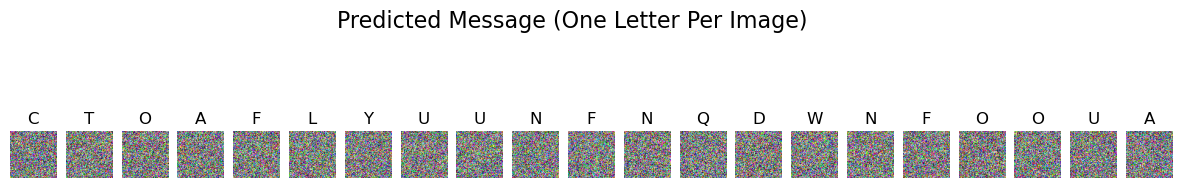

🔍 Raw Model Prediction: CTOAFLYUUNFNQDWNFOOUA


In [48]:
decode_message(model, transform, device)
visualize_decoded_message(model, transform, device)

